In [1]:
%run import_libs.py

### get data

In [2]:
short_list = [
    'P_2_last', 'B_1_last', 'B_3_last', 'D_39_last', 'D_41_last', 'D_45_max', 'B_28_min', 'D_42_avg', 'B_14_last',
    'D_50_last','B_5_last','B_4_last','D_44_last','P_2_min','D_46_last','D_51_avg','B_2_avg','P_2_avg','D_49_last',
    'S_3_last','S_3_avg','D_43_avg','B_4_max', 'D_39_max', 'D_43_last', 'S_5_last', 'B_7_last', 'B_18_last', 'P_3_avg', 
    'B_9_last', 'R_4_last', 'R_2_last', 'D_121_min', 'S_26_max'
]

In [3]:
df_train = get_train_data(TRAIN_PATH='./data/train.parquet')
num_features = pd.read_csv("num_feats_after_filtering.csv")["0"].to_list()
# num_features = short_list

df_train_agg = get_df_w_aggrs(df=df_train, feats=num_features)
df_train_target = get_target(TARGET_PATH='./data/train_labels.csv')
df_train = get_train_data_with_target_merged(df_train=df_train_agg, df_train_target=df_train_target)

(458913, 151)
(458913, 151)
(458913, 151)
(458913, 162)
(458913, 616)


In [4]:
df_test = get_test_data(TEST_PATH='./data/test.parquet')
df_test = get_df_w_aggrs(df=df_test, feats=num_features)

(924621, 151)
(924621, 151)
(924621, 151)
(924621, 162)
(924621, 616)


In [5]:
# оставляем только short_list
df_train = df_train[['customer_ID'] + short_list + ['target']]
df_test = df_test[['customer_ID'] + short_list]

### fit model

In [17]:
len(short_list)

34

In [16]:
# fit predict engeneering
random_state = 42
group_col = 'customer_ID'
target_col = 'target'
y, groups = df_train[target_col].values, df_train[group_col].values
fold_scores, fold_test_raw = [], []

sgkf = StratifiedGroupKFold(5, shuffle=True, random_state=random_state)

params = dict(
    learning_rate=.05, subsample=.9, subsample_freq=1,
    colsample_bytree=.8, objective='binary',
    random_state=random_state,
    max_depth=7, n_estimators=484,
    n_jobs=-1, verbosity=-1
)

for fold, (tr_idx, va_idx) in enumerate(
        sgkf.split(df_train[[group_col, target_col]], y, groups)):
    print(f"Fold {fold}")
    X_tr, X_va = df_train.iloc[tr_idx][short_list], df_train.iloc[va_idx][short_list]
    y_tr, y_va = y[tr_idx], y[va_idx]
    model = LGBMClassifier(**params)
    model.fit(X_tr, y_tr,
                eval_set=[(X_va, y_va)],
                eval_metric=lgb_amex_metric)
    pred_va = model.predict_proba(X_va)[:,1]
    sc = get_amex_metric_calculated(y_va, pred_va)
    print(f" Amex = {sc:.5f}")
    fold_scores.append(sc)
    fold_test_raw.append(model.predict_proba(df_test[short_list], raw_score=True))

Fold 0
 Amex = 0.77913
Fold 1
 Amex = 0.78145
Fold 2
 Amex = 0.78321
Fold 3
 Amex = 0.77928
Fold 4
 Amex = 0.78402


In [18]:
mean_cv = float(np.mean(fold_scores))
print(f"Mean CV Amex = {mean_cv:.5f}")

Mean CV Amex = 0.78142


In [ ]:
model_full = LGBMClassifier(**params).fit(
    df_train[short_list], df_train[target_col])

gains = model_full.booster_.feature_importance('gain')
imp_df = (pd.DataFrame({'feature': short_list, 'gain': gains})
            .sort_values('gain', ascending=False))
imp_df['share'] = imp_df['gain'] / imp_df['gain'].sum()

In [22]:
with open("list_perm_imp_dfs.pkl", "rb") as f:
    perm_imp_df = pickle.load(f)

In [33]:
df_imp_merged = (imp_df
.merge(perm_imp_df[40]['importance'], on='feature')
)

df_imp_merged.columns = ["feature", "imp_gain", 'share_gain', 'imp_perm']
df_imp_merged['share_perm'] = df_imp_merged['imp_perm'] / df_imp_merged['imp_perm'].sum()

In [ ]:
df_imp_merged.head(3)

,feature,imp_gain,share_gain,imp_perm,share_perm
0,P_2_last,1.392982e+06,0.451848,0.053632,0.250459
1,P_2_avg,3.099985e+05,0.100556,0.004279,0.019985
2,P_2_min,2.498633e+05,0.081049,0.004871,0.022745


In [37]:
# save importance df final model
df_imp_merged.to_csv("gain_and_permutation_feature_importance_short_list.csv", index=None)

### hyperparameter search (optuna)

In [ ]:
# optuna
# model_full = LGBMClassifier(**params).fit(
#     df_train[short_list], df_train[target_col])

In [6]:
def run_final_optuna_tuning(X, y, groups, cat_feats=None, random_state=42, n_trials=50):
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)

    def objective(trial):
        params = {
            'learning_rate': 0.05,
            'max_depth': trial.suggest_int("max_depth", 3, 10),
            'n_estimators': trial.suggest_int("n_estimators", 200, 800),
            'subsample': trial.suggest_float("subsample", 0.6, 1.0),
            'subsample_freq': 1,
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.6, 1.0),
            'reg_alpha': trial.suggest_float("reg_alpha", 0.0, 10.0),
            'reg_lambda': trial.suggest_float("reg_lambda", 0.0, 10.0),
            'random_state': random_state,
            'objective': 'binary',
            'n_jobs': -1,
            'verbosity': -1
        }

        fold_scores = []
        for tr_idx, va_idx in sgkf.split(X, y, groups):
            model = LGBMClassifier(**params)
            model.fit(X.iloc[tr_idx], y[tr_idx],
                      categorical_feature=cat_feats)
            pred = model.predict_proba(X.iloc[va_idx])[:, 1]
            score = get_amex_metric_calculated(y[va_idx], pred)
            fold_scores.append(score)

        return -np.mean(fold_scores)  # minimize negative amex

    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=random_state))
    study.optimize(objective, n_trials=n_trials, n_jobs=-1, show_progress_bar=True)

    print("Best score:", -study.best_value)
    print("Best params:", study.best_params)

    return study.best_params, study


In [9]:
random_state = 42
group_col = 'customer_ID'
target_col = 'target'
y_train, groups = df_train[target_col].values, df_train[group_col].values
fold_scores, fold_test_raw = [], []


best_params, study = run_final_optuna_tuning(
    df_train[short_list], y_train, groups, cat_feats=None, n_trials=50
)

[I 2025-05-15 16:11:20,119] A new study created in memory with name: no-name-8308f062-a7bb-4498-85d7-19c8fdf9a0b1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-15 16:27:29,039] Trial 5 finished with value: -0.7777788070164047 and parameters: {'max_depth': 5, 'n_estimators': 223, 'subsample': 0.8482270674359601, 'colsample_bytree': 0.7406285675919403, 'reg_alpha': 1.805093591482675, 'reg_lambda': 0.9262532698743453}. Best is trial 5 with value: -0.7777788070164047.
[I 2025-05-15 16:28:24,439] Trial 0 finished with value: -0.7800446206785838 and parameters: {'max_depth': 7, 'n_estimators': 221, 'subsample': 0.7595408270962891, 'colsample_bytree': 0.9336390760778533, 'reg_alpha': 7.123240857451581, 'reg_lambda': 0.9850634279267501}. Best is trial 0 with value: -0.7800446206785838.
[I 2025-05-15 16:31:46,477] Trial 7 finished with value: -0.781315275634358 and parameters: {'max_depth': 10, 'n_estimators': 274, 'subsample': 0.6967860291096907, 'colsample_bytree': 0.7753019688077294, 'reg_alpha': 0.8028714336215914, 'reg_lambda': 0.3855236636318182}. Best is trial 7 with value: -0.781315275634358.
[I 2025-05-15 16:31:49,453] Trial 4 fini

In [12]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()

In [ ]:
# save pickle final model

### interpreting results

In [38]:
model_full

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=7,
               n_estimators=484, n_jobs=-1, objective='binary', random_state=42,
               subsample=0.9, subsample_freq=1, verbosity=-1)

In [42]:
df_train[short_list].shape

(458913, 34)

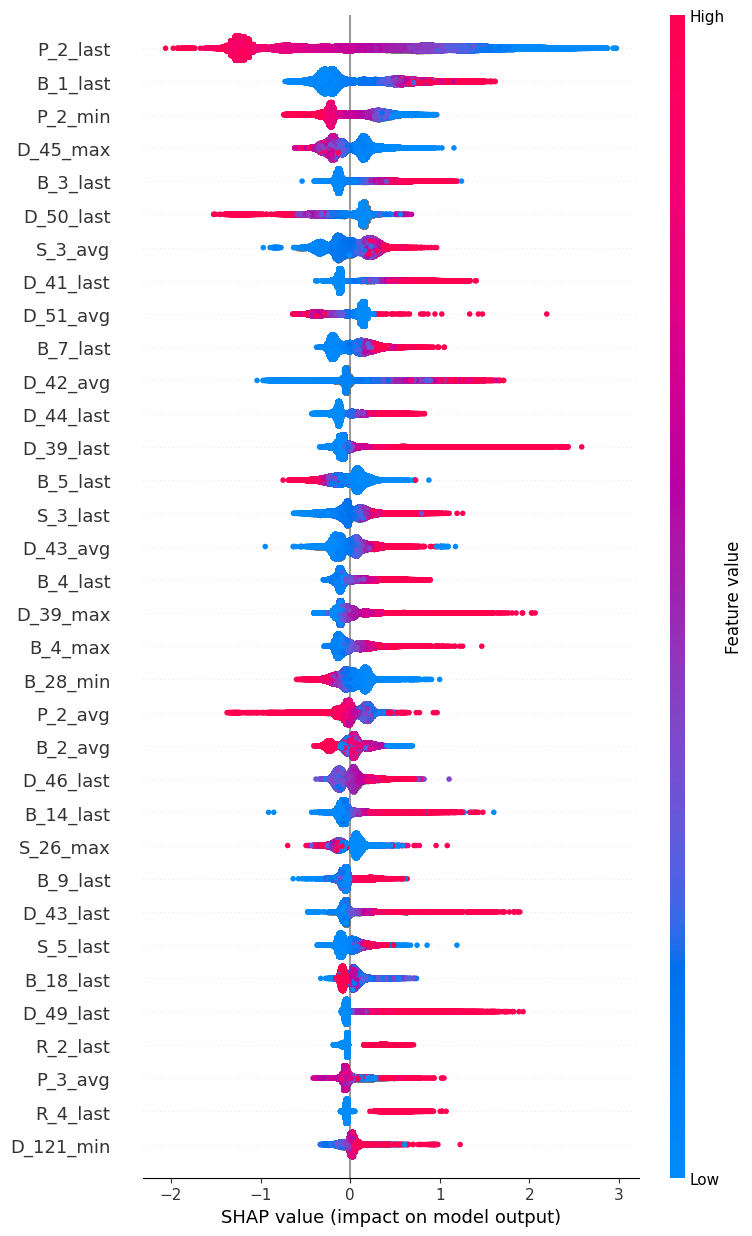

In [ ]:
# shap на train-е
explainer = shap.Explainer(model_full)
explanation = explainer(df_train[short_list])
shap.plots.beeswarm(explanation, max_display=None)

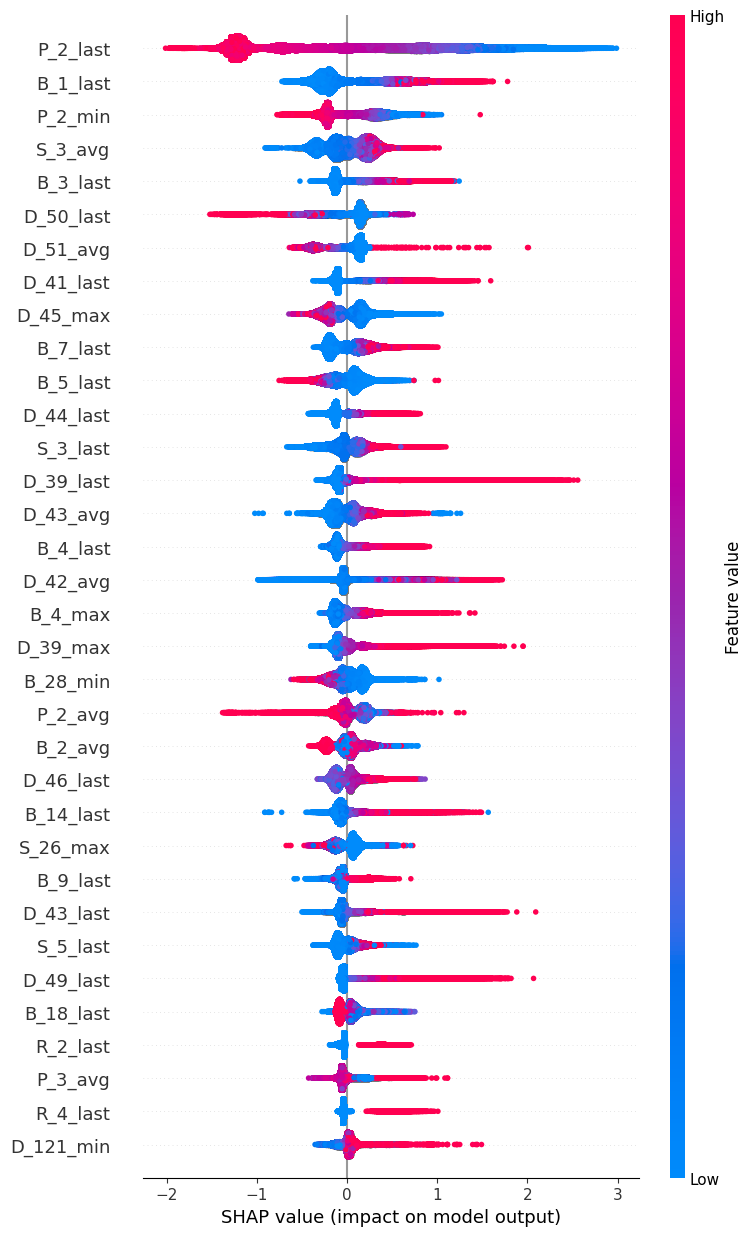

In [48]:
# shap на тесте
explainer = shap.Explainer(model_full)
explanation = explainer(df_test[short_list])
shap.plots.beeswarm(explanation, max_display=None)